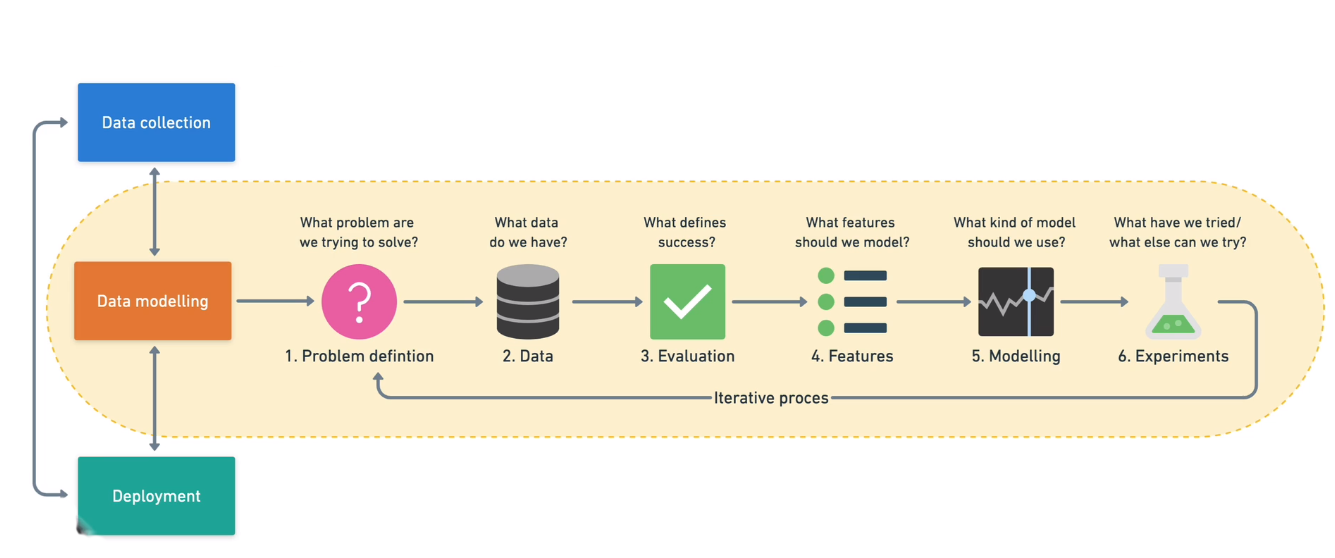

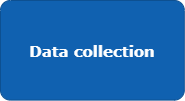
Voor het leren van een model heb ik data nodig. Automations komen in een yaml formaat.
Ik heb een aantal automations gedownload vanuit mijn Home Assistant omgeving en een aantal gekregen van familie en vrienden. Ik zal deze gebruiken om het model te trainen.
Inmiddels heb ik ~110 automations in yaml formaat. Een voorbeeld:

``` YAML
alias: 'Turn off the coffee machine after 30 minutes'
trigger:
  platform: state
  entity_id: switch.coffee_machine
  to: 'on'
  for:
    minutes: 30
action:
  - service: switch.turn_off
    target:
      entity_id: switch.coffee_machine
```

<br>

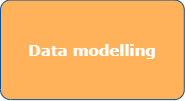
Om de bestanden om te zetten naar een dataset die op zijn beurt gebruikt kan worden om een model te trainen.

De volgende stappen ga ik doorlopen om de data gereed te maken:
- Converteer the yaml bestanden naar Python dictionaries
- Extraheer de features
- Encode de features (ML modellen kunnen niet overweg met strings. Deze moeten omgezet worden naar numerieke waarden)

#### Inlezen van yaml bestanden
``` Python
import yaml

def load_yaml_file(file_path):
    with open(file_path, 'r') as file:
        return yaml.safe_load(file)

automations = [load_yaml_file(file_path) for file_path in file_paths]
```
Deze code zorgt ervoor de yaml bestanden ingeladen worden.

#### Extraheren van features
Meestal wordt er gebruik gemaakt van OneHotEncoder van scikitlearn. OneHotEncoder doet dit door elke categorie nieuwe kolommen aan te maken en deze weer te geven met 1-en en 0-en.
Voorbeeld:
~~~
Een dataset heeft een kolom genaamd "Fruit Type" die drie mogelijke waarden kan hebben: appel, banaan en sinaasappel. Wanneer de OneHotEncoder toegepast wordt op deze dataset, creëert het drie nieuwe kolommen: "Is appel", "Is banaan" en "Is sinaasappel".
~~~
Voor een automation kan dit niet toegepast worden een automation kan 1 of meerdere triggers hebben, dit geldt ook voor de conditie en acties. Hierdoor zou het aantal kolommen toenemen per automation. Dit zou geen waarde toevoegen.  

Een andere optie zou zijn om een nieuwe tabel bij te voegen en dan relaties aanmaken.

Een betere aanpak zou zijn door de klasse LabelEncoder te gebruiken. De vervangt alle waarden in de kolom door unieke waarden. Wanneer een dezelfde waarde voorkomt krijgt die hetzelfde kenmerk.
Dezelfde klasse kan ook weer gebruikt worden om de data te de-encoden.

``` Python
from sklearn.preprocessing import LabelEncoder

# Extract features
trigger_types = [automation['trigger']['platform'] for automation in automations]
action_services = [automation['action']['service'] for automation in automations]

# Label encode features
trigger_encoder = LabelEncoder()
action_encoder = LabelEncoder()

encoded_trigger_types = trigger_encoder.fit_transform(trigger_types)
encoded_action_services = action_encoder.fit_transform(action_services)
```
Deze code zorgt ervoor dat alle unieke strings worden omgezet naar een numerieke waarden.

#### Trigger, Condities, Acties
**Triggers**: Dit zijn de events die de verwerking van een automatiseringsregel starten. Ze kunnen worden getriggerd door een event, een bepaalde status van een entiteit, op een bepaald tijdstip, en meer. Ze kunnen rechtstreeks worden gespecificeerd of flexibeler via sjablonen. Voor één automation kunnen meerdere triggers worden gespecificeerd.

**Condities**: Dit zijn optionele onderdelen van een automation en kunnen worden gebruikt om te voorkomen dat een actie plaatsvindt wanneer deze wordt getriggerd. Wanneer een conditie niet waar is, stopt de automation met uitvoeren. Condities lijken erg op triggers, maar zijn heel verschillend. Een trigger kijkt naar gebeurtenissen in het systeem, terwijl een coniditie alleen kijkt naar hoe het systeem er nu uitziet.

**Acties**: Dit is wat er wordt uitgevoerd wanneer een regel afgaat. Het actie volgt de script syntax die kan worden gebruikt om met alles te interageren via services of events. Voor services kan je de entity_id specificeren waarop het van toepassing moet zijn en parameters. Condities kunnen ook deel uitmaken van een actie.

In [3]:
%pip install PyYAML

  Using cached PyYAML-6.0-cp311-cp311-win_amd64.whl (143 kB)


In [1]:
# Description: This script is used to convert the YAML file to a Python dictionary.

import os
import yaml
from datetime import datetime, time


def process_condition(condition):
    condition_dict = {}

    if 'condition' in condition:
        condition_dict['condition'] = condition['condition']
    if 'before' in condition:
        if condition['before'] in ['sunset', 'sunrise']:
            condition_dict['before'] = condition['before']  # or any other value to represent 'sunset' or 'sunrise'
        else:
            condition_dict['before'] = datetime.strptime(condition['before'], '%H:%M:%S').time()

    return condition_dict


def process_automations(file):
    with open(file, 'r') as stream:
        data_loaded = yaml.safe_load(stream)

    # Check if data_loaded is a list, if not, convert it to a list
    if not isinstance(data_loaded, list):
        data_loaded = [data_loaded]

    automations = []

    for automation in data_loaded:
        automation_dict = {}

        # Process triggers
        triggers = automation.get('trigger', [])
        # Check if triggers is a list, if not, convert it to a list
        if not isinstance(triggers, list):
            triggers = [triggers]
        automation_dict['triggers'] = [process_trigger(trigger) for trigger in triggers]

        # Process conditions
        conditions = automation.get('condition', [])
        # Check if conditions is a list, if not, convert it to a list
        if not isinstance(conditions, list):
            conditions = [conditions]
        automation_dict['conditions'] = [process_condition(condition) for condition in conditions]

        # Process actions
        actions = automation.get('action', [])
        # Check if actions is a list, if not, convert it to a list
        if not isinstance(actions, list):
            actions = [actions]
        automation_dict['actions'] = [process_action(action) for action in actions]

        automations.append(automation_dict)

    return automations


def process_trigger(trigger):
    print(trigger)  # Add this line
    trigger_dict = {}

    if 'platform' in trigger:
        trigger_dict['platform'] = trigger['platform']
    if 'entity_id' in trigger:
        trigger_dict['entity_id'] = trigger['entity_id']
    if 'to' in trigger:
        trigger_dict['to'] = trigger['to']

    return trigger_dict


def process_action(action):
    action_dict = {}

    if 'service' in action:
        action_dict['service'] = action['service']
    if 'target' in action:
        action_dict['target'] = action['target']

    return action_dict


def correct_yaml_files(directory):
    for filename in os.listdir(directory):
        if filename.endswith(".yaml"):
            file = os.path.join(directory, filename)
            with open(file, 'r') as stream:
                try:
                    data = yaml.safe_load(stream)
                    with open(file, 'w') as output_stream:
                        yaml.dump(data, output_stream, default_flow_style=False)
                    print(f"File '{filename}' corrected.")
                except yaml.YAMLError as e:
                    print(f"Error in file '{filename}': {e}")


if __name__ == '__main__':
    directory = 'D:/Temp/yaml/'
    automations = []

    correct_yaml_files(directory)

    # loop through all the yaml files in the directory D:/Temp/yaml
    for filename in os.listdir(directory):
        if filename.endswith(".yaml"):
            print("Processing file: " + filename)
            file = os.path.join(directory, filename)
            file_automations = process_automations(file)
            automations.extend(file_automations)

    print(automations)


File 'automation_1.yaml' corrected.
File 'automation_10.yaml' corrected.
File 'automation_11.yaml' corrected.
File 'automation_12.yaml' corrected.
File 'automation_13.yaml' corrected.
File 'automation_14.yaml' corrected.
File 'automation_15.yaml' corrected.
File 'automation_16.yaml' corrected.
File 'automation_17.yaml' corrected.
File 'automation_18.yaml' corrected.
File 'automation_19.yaml' corrected.
File 'automation_2.yaml' corrected.
File 'automation_20.yaml' corrected.
File 'automation_21.yaml' corrected.
File 'automation_22.yaml' corrected.
File 'automation_23.yaml' corrected.
File 'automation_24.yaml' corrected.
File 'automation_25.yaml' corrected.
File 'automation_26.yaml' corrected.
File 'automation_27.yaml' corrected.
File 'automation_28.yaml' corrected.
File 'automation_29.yaml' corrected.
File 'automation_3.yaml' corrected.
File 'automation_30.yaml' corrected.
File 'automation_4.yaml' corrected.
File 'automation_5.yaml' corrected.
File 'automation_6.yaml' corrected.
File 'a

#### Preprocessing
De data is nu opgeslagen in dictionaries. De volgende stap is om deze data geschikt te maken om een model te trainen.

In [5]:
%pip install scikit-learn

  Using cached scikit_learn-1.2.2-cp311-cp311-win_amd64.whl (8.3 MB)
  Using cached numpy-1.24.3-cp311-cp311-win_amd64.whl (14.8 MB)
  Using cached scipy-1.10.1-cp311-cp311-win_amd64.whl (42.2 MB)
  Using cached joblib-1.2.0-py3-none-any.whl (297 kB)
  Using cached threadpoolctl-3.1.0-py3-none-any.whl (14 kB)
Note: you may need to restart the kernel to use updated packages.


In [7]:
from sklearn.preprocessing import LabelEncoder

# Initialize the encoders
platform_encoder = LabelEncoder()
condition_encoder = LabelEncoder()
service_encoder = LabelEncoder()

# Initialize lists to store the features
platforms = []
conditions = []
services = []

# Loop through all the automations
for automation in automations:
    # Loop through all the triggers, conditions, and actions
    for trigger in automation['triggers']:
        platforms.append(trigger['platform'])
    for condition in automation['conditions']:
        conditions.append(condition['condition'])
    for action in automation['actions']:
        services.append(action['service'])

# Fit and transform the features using the encoders
encoded_platforms = platform_encoder.fit_transform(platforms)
encoded_conditions = condition_encoder.fit_transform(conditions)
encoded_services = service_encoder.fit_transform(services)

encoded_platforms, encoded_conditions, encoded_services

(array([1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1], dtype=int64),
 array([2, 0, 1, 1, 1, 3, 2, 2, 2, 2, 1, 3, 2, 2, 2, 2, 2], dtype=int64),
 array([2, 1, 0, 1, 2, 5, 4, 6, 5, 3, 2, 2, 1, 4, 2, 1, 2, 1, 4, 6, 3, 2,
        2, 4, 2, 2, 2, 2, 1], dtype=int64))

#### Feature extraction
Extractie van kenmerken(Feature extraction) is het proces waarbij ruwe gegevens worden omgezet in kenmerken die kunnen worden gebruikt om een model voor machine learning(ML) te trainen. In deze context van Home Assistant automations betekend dit dat nieuwe kenmerken gecreëerd moeten worden die een bepaald aspect van de automations weergeven.

Het idee is om het volgende te doen:

**Aantal triggers, condities en acties**: Het aantal triggers, condities en acties in elke automation kan een nuttig kenmerk zijn. Sommige automations kunnen meerdere triggers of acties hebben, en dit kan relevant zijn voor het model.

**Aanwezigheid van bepaalde triggers, condities of acties**: Ik kan hiervoor binaire kenmerken(0 of 1) maken die de aanwezigheid van bepaalde triggers, condities of acties in elke automation aangeven. U kunt bijvoorbeeld een kenmerk hebben dat 1 is als de automation een "state" trigger heeft en 0 anders.

**Tijd**: Als automations op tijd gebaseerd zijn, kan het tijdstip van de dag een nuttig kenmerk zijn. Ik zou dit kunnen halen uit het veld "at" in tijdgebaseerde triggers.

##### Onderbouwing
De reden waarom ik hiervoor gekozen is dat bepaalde triggers, condities of acties kunnen vaker voorkomen in bepaalde typen automations. Een "toestand"-trigger kan bijvoorbeeld vaker voorkomen in automations die verlichting aansturen, terwijl een "tijd"-trigger vaker voorkomt in automations die thermostaten aansturen. Door deze kenmerken op te nemen, kan het model leren onderscheid te maken tussen verschillende soorten automations op basis van de triggers, condities en acties die ze bevatten.

De aanwezigheid van bepaalde triggers, condities of acties kan de complexiteit van een automation aangeven. Zo kan een automation met een 'template'-trigger of -conditie complexer zijn dan een automation met alleen 'state'-triggers en -condities. Het model kan deze informatie gebruiken om de structuur en complexiteit van de automations beter te begrijpen.

Er kunnen interacties zijn tussen verschillende triggers, condities en acties. Een automation kan bijvoorbeeld eerder een "zon"-voorwaarde bevatten als een "tijd"-trigger. Door de aanwezigheid van bepaalde triggers, condities of acties als kenmerken op te nemen, kan het model leren deze interacties te herkennen.

Bepaalde triggers, omstandigheden of acties kunnen voorspellend zijn voor de output die ik probeer te voorspellen. Als ik bijvoorbeeld probeert te voorspellen of een automation een licht in schakelt, zou de aanwezigheid van een actie "light.turn_on" voorspellend zijn. Door deze als kenmerken op te nemen, kan het de prestaties van het model verbeteren.

In [11]:
# Initialize lists to store the features
num_triggers = []
num_conditions = []
num_actions = []
has_state_trigger = []
has_sunrise_trigger = []

# Loop through all the automations
for automation in automations:
    # Extract features
    num_triggers.append(len(automation['triggers']))
    num_conditions.append(len(automation['conditions']))
    num_actions.append(len(automation['actions']))
    has_state_trigger.append(any(trigger['platform'] == 'state' for trigger in automation['triggers']))
    has_sunrise_trigger.append(any(trigger['platform'] == 'sun' and trigger.get('event') == 'sunrise' for trigger in automation['triggers']))

# Only show the first 5 values
num_triggers[:5], num_conditions[:5], num_actions[:5], has_state_trigger[:5], has_sunrise_trigger[:5]

([1, 1, 2, 1, 1],
 [1, 0, 1, 0, 1],
 [1, 1, 1, 1, 1],
 [True, True, True, True, True],
 [False, False, False, False, False])

![Data Modelling](Images/Workflow/Data_modelling.png) **Data Modelling**: In deze stap moet er gekeken worden wat de dataset bevat. Zo mogen er geen lege velden voorkomen. Een leeg veld heeft nadelige invloed in het trainen van het model. De meeste modellen werken met getallen, er zal gekeken moeten worden of de gegevens in de dataset aangepast kunnen worden.
Zo kan simpel een true of false waarde vertaald worden naar een 0 of 1.

Als laatste waar op gelet moet worden zijn de verschillen tussen de waardes. Bijvoorbeeld als je een prijs van een huis gaat voorspellen en deze voorkomt als 650000 kan het zijn dat het model hier een hogere waarde aan kent tijdens het voorspellen wat het voorspellen erg kan beïnvloeden.
Door de getallen dichter op elk te zetten kan het model nauwkeuriger voorspellen. Je kan er dan voor kiezen om de kolom prijzen aan te passen en de bedragen te delen door 1000.

<br>

![Deployment](Images/Workflow/Deployment.png) **"Deployment"**: In de context van de workflow voor machine learning verwijst dit naar de integratie van het model voor machine learning in een productieomgeving waar het voorspellingen kan doen op nieuwe gegevens. Dit is de fase waarin het model, na training en validatie, gebruikt wordt.

<br>

![Problem definition](Images/Workflow/Problem_definition.png) **Problem definition**: Het probleem duidelijk definiëren. Dit is een cruciale stap. Het is belangrijk om te begrijpen wat wil ik gaan voorspellen en welke gegevens heb ik. Het heeft geen zin om een model te trainen als niet duidelijk is wat ik wil voorspellen of dat de aanwezige data niet toereikend is.

<br>

![Data](Images/Workflow/Data.png) **Data**:
In deze stap wordt er naar de data gekeken. Dit kan raar klinken maar na het opschonen en gereed maken van de data om een model te trainen moet de data ook begrepen worden. Een goede methode is om grafieken van te maken. Hierdoor wordt je gedwongen om erover na te denken wat in een later stadium gebruikt kan worden bij de validatie van het model.

<br>

![Evaluation](Images/Workflow/Evaluation.png) **Evaluation**: Bepalen hoe succes eruit ziet. Ben ik tevreden bij een bepaalde score hoe het model functioneert of dat het model een bepaalde waarde goed weet te schatten.

<br>

![Features](Images/Workflow/Features.png) **Feature engineering**: Beslissen welke kenmerken er gemodelleerd moeten worden. Dit kan betekenen dat uit de bestaande gegevens nieuwe kenmerken worden gecreëerd die meer informatie opleveren voor het model. Dit kan complex klinken maar denk aan het voorspellen wanneer iemand een hartziekte heeft. Als deze voorspelling goed genoeg is kan deze waarde weer gebruikt worden in andere voorspellingen.

<br>

![Modelling](Images/Workflow/Modelling.png) **Modelling**: In deze stap kunnen verschillende soorten modellen worden uitgeprobeerd en de parameters ervan worden afgestemd.

Na het proberen van verschillende modellen volgt automatisch modelvalidatie. Wanneer je een model traint op de trainingsset en vervolgens evalueert op de testset. Kan er bepaald worden hoe het model zich gedraagt. Als vervolgstap kan er een fijnafstemming plaatsvinden door het automatisch aanpassen van hyperparameters(specificieke paramters, deze kunnen verschillen per model) om tot een beter resultaat te komen.

<br>

![Experiments](Images/Workflow/Experiments.png) **Experiments**: Een belangrijke stap, probeer eens een ander model om de gemaakte keuzes na te gaan of deze wel goed zijn of dat een ander model misschien toch beter presteerd.

<br>